## Context
Satellite image Classification Dataset-RSI-CB256 , This dataset has 4 different classes mixed from Sensors and google map snapshot

## Content
The past years have witnessed great progress on remote sensing (RS) image interpretation and its wide applications. With RS images becoming more accessible than ever before, there is an increasing demand for the automatic interpretation of these images. In this context, the benchmark datasets serve as essential prerequisites for developing and testing intelligent interpretation algorithms. After reviewing existing benchmark datasets in the research community of RS image interpretation, this article discusses the problem of how to efficiently prepare a suitable benchmark dataset for RS image interpretation. Specifically, we first analyze the current challenges of developing intelligent algorithms for RS image interpretation with bibliometric investigations. We then present the general guidance on creating benchmark datasets in efficient manners. Following the presented guidance, we also provide an example on building RS image dataset, i.e., Million-AID, a new large-scale benchmark dataset containing a million instances for RS image scene classification. Several challenges and perspectives in RS image annotation are finally discussed to facilitate the research in benchmark dataset construction. We do hope this paper will provide the RS community an overall perspective on constructing large-scale and practical image datasets for further research, especially data-driven ones.

## Task 1: Create a classification model in Pytorch
## Task 2: Study what is Data augmentation, explain it and apply it

In [427]:
# prompt: import drive

#from google.colab import drive
#drive.mount('/content/drive')

In [428]:
import os
#for dirname, _, filenames in os.walk('/content/drive/MyDrive/DataIntesive/Data/Data_satellite'):
#    print(dirname)

# Folder Data_satellite contains 3 subfolders: cloudy, water, green_area and desert
for dirname, _, filenames in os.walk('Data_satellite'):
    print(dirname)

Data_satellite
Data_satellite/cloudy
Data_satellite/water
Data_satellite/green_area
Data_satellite/desert


In [429]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [430]:
from tqdm import tqdm

# We reduce image size to reduce computational cost

In [431]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [432]:
# dataset = ImageFolder('/content/drive/MyDrive/DataIntesive/Data/Data_satellite/', transform=transform)
dataset = ImageFolder('Data_satellite/', transform=transform)

In [433]:
dataset[1][0].shape

torch.Size([3, 64, 64])

# Check Classes

In [434]:
dataset.classes

['cloudy', 'desert', 'green_area', 'water']

In [435]:
len(dataset)

832

In [436]:
from collections import Counter
value_counts = dict(Counter(dataset.targets))

In [437]:
value_counts = dict(zip(dataset.classes, value_counts.values()))

print(value_counts)

{'cloudy': 201, 'desert': 210, 'green_area': 214, 'water': 207}


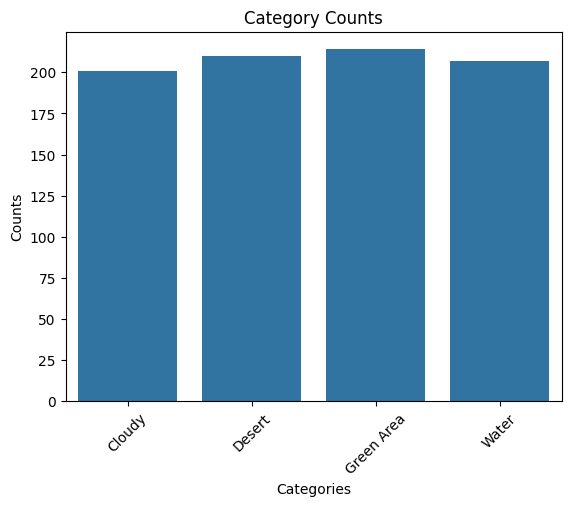

In [438]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=list(value_counts.keys()), y= list(value_counts.values()))
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Category Counts')
plt.xticks(range(4),labels = ["Cloudy", "Desert", "Green Area", "Water"], rotation = 45)
plt.show()

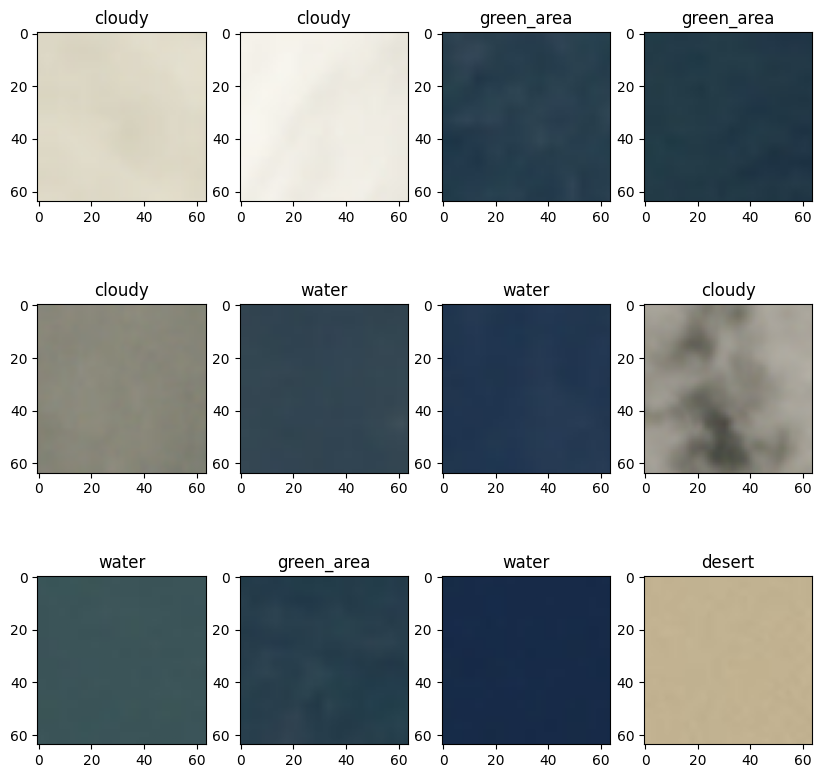

In [439]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns * rows + 1):
    idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[idx]
    class_name = dataset.classes[label]
    fig.add_subplot(rows, columns, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [440]:
test_size = 0.2

num_dataset = len(dataset)
num_test = int(num_dataset * test_size)
num_train = num_dataset - num_test
print('Number of Points in Dataset - {0}'.format(num_dataset))
print('Number of Points in Training Dataset - {0}'.format(num_train))
print('Number of Points in Testing Dataset - {0}'.format(num_test))

Number of Points in Dataset - 832
Number of Points in Training Dataset - 666
Number of Points in Testing Dataset - 166


In [441]:
train_set, test_set = torch.utils.data.random_split(dataset, [num_train, num_test])
train_set[0][0].shape

torch.Size([3, 64, 64])

In [442]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

## Task 1

In [447]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3 channels (RGB), 32 filters
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling 2x2
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 filters
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2
        
        # Fully connected layers
        # After 2 pooling layers: 64 -> 32 -> 16
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        self.fc2 = nn.Linear(512, 4)  # 4 output classes for satellite images

    def forward(self, x):
        # First block
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        
        # Second block
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 64 * 16 * 16)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
model = CNNModel()

In [448]:
# # Move the model to the available device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [449]:
criterion = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr =  0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4) # with L2 regularisation

In [450]:
def train(model, optimiser):
    # Training loop
    train_accuracies = []
    test_accuracies = []
    num_epochs = 25
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track train loss and accuracy
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate train accuracy and loss
        train_accuracy = correct_train / total_train
        train_loss = train_loss / total_train

        train_accuracies.append(train_accuracy)
        # Evaluation (Test)
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_predictions = []
        all_targets = []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                            # Track test loss and accuracy
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        # Calculate test accuracy and loss
        test_accuracy = correct_test / total_test
        test_loss = test_loss / total_test

        test_accuracies.append(test_accuracy)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

In [451]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [452]:
train(model, optimizer)

100%|██████████| 84/84 [00:03<00:00, 23.84it/s]


Epoch 1/25 - Train Loss: 0.8474 - Train Acc: 0.5706 - Test Loss: 0.5683 - Test Acc: 0.8193


100%|██████████| 84/84 [00:02<00:00, 30.66it/s]


Epoch 2/25 - Train Loss: 0.6989 - Train Acc: 0.6486 - Test Loss: 0.6435 - Test Acc: 0.6627


100%|██████████| 84/84 [00:02<00:00, 28.07it/s]


Epoch 3/25 - Train Loss: 0.5871 - Train Acc: 0.7207 - Test Loss: 0.6534 - Test Acc: 0.6325


100%|██████████| 84/84 [00:04<00:00, 19.68it/s]


Epoch 4/25 - Train Loss: 0.5625 - Train Acc: 0.7432 - Test Loss: 0.4854 - Test Acc: 0.7229


100%|██████████| 84/84 [00:03<00:00, 21.64it/s]


Epoch 5/25 - Train Loss: 0.5776 - Train Acc: 0.7432 - Test Loss: 0.4235 - Test Acc: 0.8313


100%|██████████| 84/84 [00:02<00:00, 28.34it/s]


Epoch 6/25 - Train Loss: 0.4783 - Train Acc: 0.7868 - Test Loss: 1.4437 - Test Acc: 0.5542


100%|██████████| 84/84 [00:02<00:00, 29.58it/s]


Epoch 7/25 - Train Loss: 0.4911 - Train Acc: 0.7598 - Test Loss: 1.0898 - Test Acc: 0.6205


100%|██████████| 84/84 [00:03<00:00, 26.78it/s]


Epoch 8/25 - Train Loss: 0.4445 - Train Acc: 0.7988 - Test Loss: 0.4359 - Test Acc: 0.7952


100%|██████████| 84/84 [00:02<00:00, 28.82it/s]


Epoch 9/25 - Train Loss: 0.5139 - Train Acc: 0.7628 - Test Loss: 0.4324 - Test Acc: 0.8193


100%|██████████| 84/84 [00:03<00:00, 25.88it/s]


Epoch 10/25 - Train Loss: 0.4671 - Train Acc: 0.7913 - Test Loss: 0.6340 - Test Acc: 0.7651


100%|██████████| 84/84 [00:02<00:00, 30.69it/s]


Epoch 11/25 - Train Loss: 0.4636 - Train Acc: 0.7958 - Test Loss: 0.6016 - Test Acc: 0.7289


100%|██████████| 84/84 [00:02<00:00, 28.97it/s]


Epoch 12/25 - Train Loss: 0.4899 - Train Acc: 0.7868 - Test Loss: 0.6299 - Test Acc: 0.7289


100%|██████████| 84/84 [00:03<00:00, 26.40it/s]


Epoch 13/25 - Train Loss: 0.4388 - Train Acc: 0.8048 - Test Loss: 0.6016 - Test Acc: 0.7289


100%|██████████| 84/84 [00:03<00:00, 27.71it/s]


Epoch 14/25 - Train Loss: 0.3972 - Train Acc: 0.8393 - Test Loss: 0.3778 - Test Acc: 0.8434


100%|██████████| 84/84 [00:02<00:00, 28.44it/s]


Epoch 15/25 - Train Loss: 0.4141 - Train Acc: 0.8198 - Test Loss: 0.3953 - Test Acc: 0.8253


100%|██████████| 84/84 [00:03<00:00, 23.93it/s]


Epoch 16/25 - Train Loss: 0.4088 - Train Acc: 0.8423 - Test Loss: 0.3472 - Test Acc: 0.8313


100%|██████████| 84/84 [00:02<00:00, 28.01it/s]


Epoch 17/25 - Train Loss: 0.4047 - Train Acc: 0.8303 - Test Loss: 0.4120 - Test Acc: 0.8193


100%|██████████| 84/84 [00:02<00:00, 29.46it/s]


Epoch 18/25 - Train Loss: 0.3969 - Train Acc: 0.8348 - Test Loss: 0.9371 - Test Acc: 0.6205


100%|██████████| 84/84 [00:03<00:00, 26.94it/s]


Epoch 19/25 - Train Loss: 0.4206 - Train Acc: 0.8183 - Test Loss: 0.3233 - Test Acc: 0.8855


100%|██████████| 84/84 [00:03<00:00, 26.12it/s]


Epoch 20/25 - Train Loss: 0.3629 - Train Acc: 0.8559 - Test Loss: 0.4286 - Test Acc: 0.8795


100%|██████████| 84/84 [00:03<00:00, 27.96it/s]


Epoch 21/25 - Train Loss: 0.3590 - Train Acc: 0.8498 - Test Loss: 0.3437 - Test Acc: 0.8434


100%|██████████| 84/84 [00:02<00:00, 29.98it/s]


Epoch 22/25 - Train Loss: 0.4013 - Train Acc: 0.8303 - Test Loss: 0.3275 - Test Acc: 0.8976


100%|██████████| 84/84 [00:02<00:00, 28.17it/s]


Epoch 23/25 - Train Loss: 0.3632 - Train Acc: 0.8634 - Test Loss: 0.2950 - Test Acc: 0.8916


100%|██████████| 84/84 [00:02<00:00, 29.57it/s]


Epoch 24/25 - Train Loss: 0.3572 - Train Acc: 0.8498 - Test Loss: 0.3336 - Test Acc: 0.8434


100%|██████████| 84/84 [00:02<00:00, 29.34it/s]


Epoch 25/25 - Train Loss: 0.3458 - Train Acc: 0.8634 - Test Loss: 0.3536 - Test Acc: 0.8855


In [453]:
print(f"Test accuracy: {evaluate(model, test_loader):.2f}%")

Test accuracy: 88.55%


## Task 2

Data augmentation is a powerful technique in machine learning and deep learning that artificially increases the size and diversity of your training dataset by creating modified versions of existing data. By applying various transformations, data augmentation aims to improve the model’s performance and robustness on unseen data by making it more invariant to common variations. This process is particularly important in cases where collecting large amounts of labeled data is challenging or costly.

WHY DO WE NEED DATA AUGMENTATION?
1. Limited Data:
    - Helps in data-scarce scenarios: Many specialized domains, like medical imaging, satellite imagery, or wildlife detection, often lack large datasets. Data augmentation allows us to generate more training samples from a limited dataset, expanding its effective size.
    - Enables deep learning models to perform well with less data: Most deep learning models require substantial amounts of data to generalize well. Data augmentation can bridge this gap when data is limited, allowing the model to capture more features without the need for additional collection efforts.

2. Prevent Overfitting:
    - Acts as a regularization technique: Data augmentation introduces randomness and variability, making it harder for the model to memorize training data. This helps reduce overfitting, a common problem where models perform well on training data but fail on new data.
    - Improves generalization by exposing models to diverse examples: Since the model encounters slightly altered versions of the data in each epoch, it learns more generalized features, making it less dependent on specific patterns in the training set.

3. Improve Generalization:
	- Creates models that are robust to real-world data variations: In real-world applications, data is often noisy, incomplete, or subject to variations that aren’t seen in the training set. Data augmentation exposes the model to similar changes, enabling it to handle variations in data such as rotations, lighting changes, or occlusions.
	- Bridges the gap between training and test data distributions: Often, there is a slight mismatch between training and test data distributions. Data augmentation introduces variations that help the model adapt better to unseen examples and improve its performance on test data.

4. Cost-Effective:
    - Saves time and resources: Data augmentation is a relatively low-cost solution compared to collecting and annotating large datasets, which can be time-consuming and resource-intensive.
	- Particularly valuable in fields with high data collection costs: For instance, obtaining satellite imagery or specialized medical scans can be expensive and difficult to label accurately. Data augmentation offers a practical way to leverage limited datasets in such cases, making it a resource-efficient alternative to large-scale data collection.

COMMON TECHNIQUES\
Data augmentation works by applying a series of transformations to the original data, creating diverse samples while retaining their semantic meaning and labels. Below are some commonly used techniques:

Geometric Transformations:
	- Flipping: Creates mirrored versions of images, often horizontally, to introduce symmetry.
	- Rotation: Random rotations of images simulate the object being viewed from different angles.
	- Cropping and Scaling: Zooms in or out on images or crops specific regions, making the model invariant to scale and positioning.
	- Translation: Shifts images slightly in various directions, ensuring the model remains robust to changes in object location.

Color and Contrast Adjustments:
	- Brightness, Contrast, and Saturation Adjustments: Variations in brightness and contrast simulate changes in lighting conditions.
	- Hue and Color Jittering: Introduces slight color shifts to adapt the model to variations in color and shading.

Noise Injection and Blurring:
	- Adding Noise: Random noise simulates sensor errors or other imperfections in real-world images.
	- Gaussian Blur: Adds blur to images to simulate motion or focus variability.

Other Advanced Techniques:
	- Cutout: Randomly masks parts of an image, forcing the model to focus on surrounding context.
	- Mixup: Combines two images to generate a new training example with interpolated labels, a method often used in neural networks.
	- Synthetic Data Generation: In some cases, generating entirely synthetic data (e.g., using GANs) can complement traditional augmentation.

POTENTIAL CHALLENGES\
While data augmentation is widely beneficial, it’s essential to implement it thoughtfully to avoid introducing noise or undesirable patterns in your training data:

1.	Over-Augmentation: Excessive transformations may distort the data and introduce artifacts, leading to degraded model performance. It’s essential to use a balanced approach and evaluate which transformations are beneficial for the specific dataset and task.

2.	Label Consistency: Not all transformations preserve the semantic meaning of data equally. For example, rotating an image of a digit ‘6’ by 180 degrees could turn it into a ‘9’. Careful consideration is necessary to avoid mislabeling issues.

3.	Computation Costs: Some augmentation techniques, especially those that generate synthetic data or require real-time augmentation during training, can be computationally demanding and slow down the training process.

In [457]:
# Augmented transforms for the training set only
train_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(64),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
])

# Basic transform for test set, similar to the one in the beginning
test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(64),
    transforms.ToTensor()
])

In [458]:
# Apply transforms only to train and test datasets
dataset = ImageFolder('Data_satellite/')
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# Use the existing train and test loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

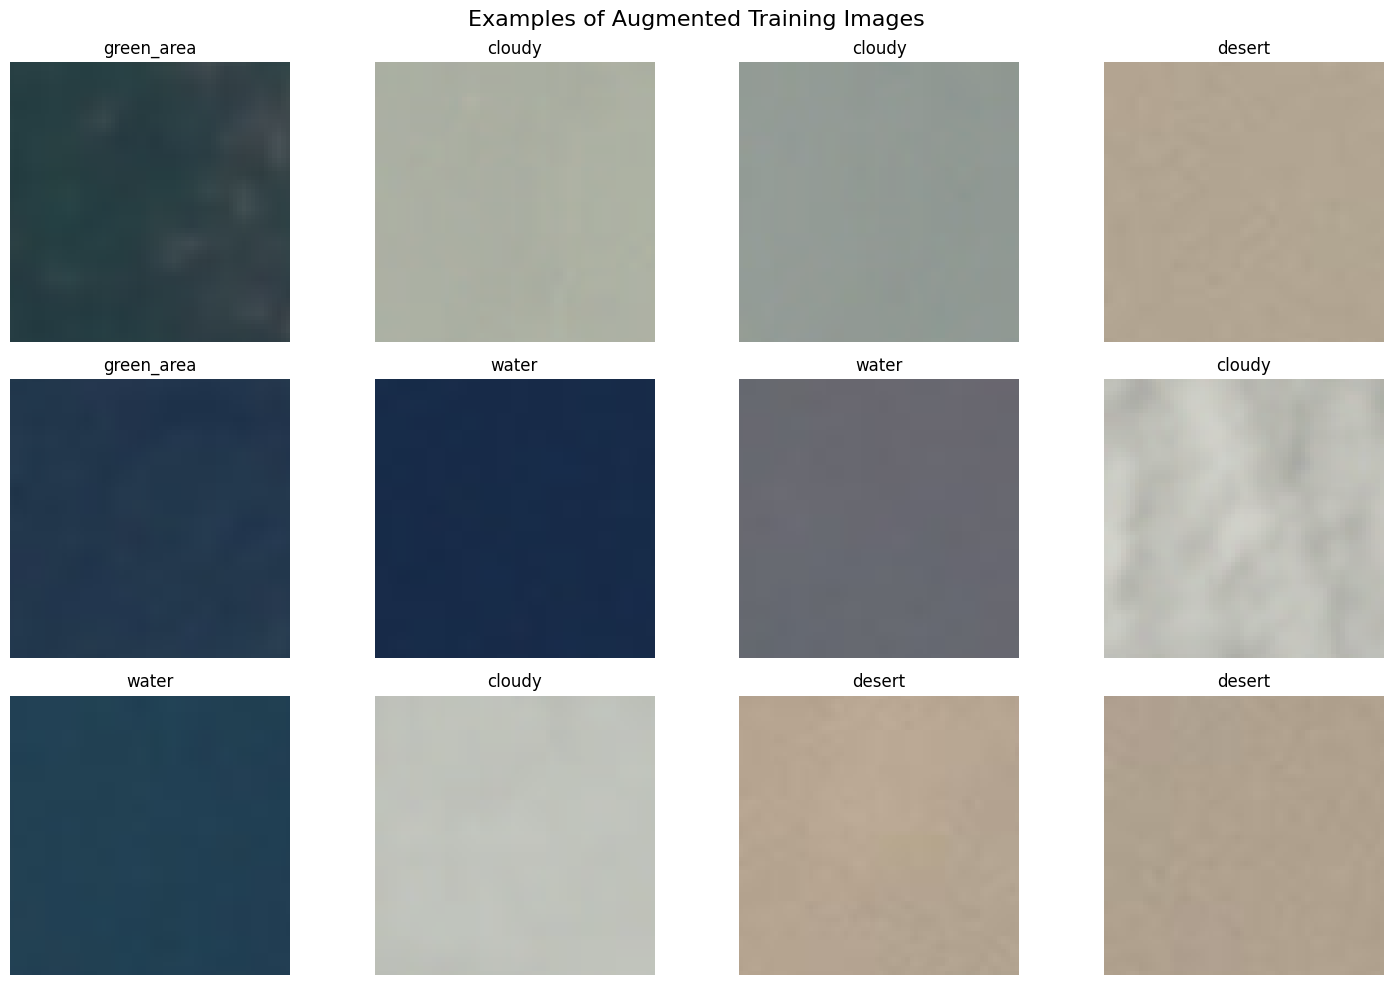

In [459]:
# Add visualization function to see the augmentations
def show_augmented_images():
    fig = plt.figure(figsize=(15, 10))
    columns = 4
    rows = 3
    
    for i in range(1, columns * rows + 1):
        idx = torch.randint(len(train_set), size=(1,)).item()
        img, label = train_set[idx]
        class_name = dataset.classes[label]
        
        fig.add_subplot(rows, columns, i)
        plt.title(f'{class_name}')
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))
    
    plt.suptitle('Examples of Augmented Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize some augmented images
show_augmented_images()